In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    mean_absolute_error, 
    f1_score, 
    classification_report,
    confusion_matrix
)

# Settings
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries imported")

✅ Libraries imported


In [ ]:
# Load cleaned data
df = pd.read_csv('data/amazon_electronics_cleaned.csv')
print(f"✅ Loaded {len(df):,} reviews")

# TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95
)

X = vectorizer.fit_transform(df['text'])
y = df['rating'].values

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"✅ Training: {X_train.shape[0]:,} | Test: {X_test.shape[0]:,}")

✅ Loaded 49,953 reviews
✅ Training: 39,962 | Test: 9,991


In [5]:
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model and return metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{'='*55}")
    print(f"📊 {model_name}")
    print(f"{'='*55}")
    print(f"Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"MAE:           {mae:.4f}")
    print(f"F1 (macro):    {f1_macro:.4f}")
    print(f"F1 (weighted): {f1_weighted:.4f}")
    
    return {
        'model': model_name,
        'encoding': 'Ordinal',
        'accuracy': accuracy,
        'mae': mae,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }


def calculate_error_rates(y_true, y_pred):
    """Calculate adjacent and severe error rates."""
    errors = y_true != y_pred
    if errors.sum() == 0:
        return 0.0, 0.0
    
    error_distances = np.abs(y_true[errors] - y_pred[errors])
    adjacent = (error_distances == 1).sum() / errors.sum()
    severe = (error_distances >= 2).sum() / errors.sum()
    
    return adjacent, severe


print("✅ Helper functions defined")

✅ Helper functions defined


In [6]:
# ============================================================================
# MODEL 1: RIDGE REGRESSION (ORDINAL)
# ============================================================================

print("\n" + "="*70)
print("🔧 MODEL 1: Ridge Regression (Ordinal)")
print("="*70)
print("\nTreats ratings as CONTINUOUS ordinal values: 1 < 2 < 3 < 4 < 5")
print("Formula: ŷ = wᵀx + b, then round to nearest integer")
print("Loss: Σ(yᵢ - ŷᵢ)² + λ||w||² (naturally penalizes large errors more)")

# Train
ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train, y_train)

# Predict (continuous) then round and clip
ridge_pred_continuous = ridge_model.predict(X_test)
ridge_pred = np.clip(np.round(ridge_pred_continuous), 1, 5).astype(int)

# Evaluate
ridge_results = evaluate_model(y_test, ridge_pred, "Ridge Regression")

# Error analysis
ridge_adjacent, ridge_severe = calculate_error_rates(y_test, ridge_pred)
ridge_results['adjacent_error'] = ridge_adjacent
ridge_results['severe_error'] = ridge_severe

print(f"\nError Analysis:")
print(f"   Adjacent Error Rate (±1): {ridge_adjacent:.2%}")
print(f"   Severe Error Rate (±2+):  {ridge_severe:.2%}")


🔧 MODEL 1: Ridge Regression (Ordinal)

Treats ratings as CONTINUOUS ordinal values: 1 < 2 < 3 < 4 < 5
Formula: ŷ = wᵀx + b, then round to nearest integer
Loss: Σ(yᵢ - ŷᵢ)² + λ||w||² (naturally penalizes large errors more)

📊 Ridge Regression
Accuracy:      0.5125 (51.25%)
MAE:           0.5935
F1 (macro):    0.3198
F1 (weighted): 0.5335

Error Analysis:
   Adjacent Error Rate (±1): 81.83%
   Severe Error Rate (±2+):  18.17%


In [7]:
# Show continuous prediction distribution
print("\n📊 Ridge Continuous Predictions:")
print(f"   Min: {ridge_pred_continuous.min():.2f}")
print(f"   Max: {ridge_pred_continuous.max():.2f}")
print(f"   Mean: {ridge_pred_continuous.mean():.2f}")

# Classification report
print("\n📋 Classification Report - Ridge:")
print(classification_report(y_test, ridge_pred, digits=4))


📊 Ridge Continuous Predictions:
   Min: -0.13
   Max: 6.12
   Mean: 4.29

📋 Classification Report - Ridge:
              precision    recall  f1-score   support

           1     0.6833    0.0723    0.1308       567
           2     0.2452    0.1481    0.1847       432
           3     0.2089    0.2673    0.2345       793
           4     0.2676    0.5426    0.3585      2020
           5     0.8129    0.5999    0.6904      6179

    accuracy                         0.5125      9991
   macro avg     0.4436    0.3261    0.3198      9991
weighted avg     0.6228    0.5125    0.5335      9991



In [8]:
# ============================================================================
# ORDINAL LOGISTIC REGRESSION CLASS
# ============================================================================

class OrdinalLogisticRegression:
    """
    Ordinal Logistic Regression using threshold (cumulative) approach.
    
    For K classes, trains K-1 binary classifiers.
    Each classifier k models: P(Y ≤ k | x) = σ(θₖ - wᵀx)
    
    This EXPLICITLY preserves ordinal structure: 1 < 2 < 3 < 4 < 5
    
    Key insight: Same feature weights w for all thresholds,
    only the threshold θₖ changes.
    """
    
    def __init__(self, max_iter=1000, C=1.0):
        self.max_iter = max_iter
        self.C = C
        self.classifiers = []
        self.classes_ = None
    
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        n_classes = len(self.classes_)
        
        print(f"   Training {n_classes - 1} binary classifiers...")
        print(f"   Classes: {self.classes_}")
        
        # Train K-1 binary classifiers for cumulative probabilities
        for k in range(n_classes - 1):
            threshold = self.classes_[k]
            # Binary target: 1 if y <= threshold, 0 otherwise
            y_binary = (y <= threshold).astype(int)
            
            clf = LogisticRegression(
                max_iter=self.max_iter, 
                C=self.C,
                random_state=42,
                solver='lbfgs'
            )
            clf.fit(X, y_binary)
            self.classifiers.append(clf)
            
            pos_rate = y_binary.mean()
            print(f"      Classifier {k+1}: P(Y ≤ {threshold}) - {pos_rate:.1%} positive")
        
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities using cumulative approach."""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        
        # Get cumulative probabilities P(Y ≤ k)
        cumulative_probs = np.zeros((n_samples, n_classes))
        cumulative_probs[:, -1] = 1.0  # P(Y ≤ max_class) = 1
        
        for k, clf in enumerate(self.classifiers):
            cumulative_probs[:, k] = clf.predict_proba(X)[:, 1]
        
        # Convert cumulative to class probabilities: P(Y = k) = P(Y ≤ k) - P(Y ≤ k-1)
        class_probs = np.zeros((n_samples, n_classes))
        class_probs[:, 0] = cumulative_probs[:, 0]  # P(Y = 1) = P(Y ≤ 1)
        
        for k in range(1, n_classes):
            class_probs[:, k] = cumulative_probs[:, k] - cumulative_probs[:, k-1]
        
        # Ensure non-negative (numerical stability)
        class_probs = np.maximum(class_probs, 0)
        
        # Normalize rows to sum to 1
        row_sums = class_probs.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        class_probs = class_probs / row_sums
        
        return class_probs
    
    def predict(self, X):
        """Predict class labels."""
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]


print("✅ OrdinalLogisticRegression class defined")

✅ OrdinalLogisticRegression class defined


In [9]:
# ============================================================================
# MODEL 2: ORDINAL LOGISTIC REGRESSION
# ============================================================================

print("\n" + "="*70)
print("🔧 MODEL 2: Ordinal Logistic Regression (Threshold-Based)")
print("="*70)
print("\nUses K-1 binary classifiers to model cumulative probabilities.")
print("Formula: P(Y ≤ k | x) = σ(θₖ - wᵀx)")
print("Class prob: P(Y = k) = P(Y ≤ k) - P(Y ≤ k-1)")
print("\nExplicitly encodes ordinal constraint: θ₁ < θ₂ < θ₃ < θ₄\n")

# Train
olr_model = OrdinalLogisticRegression(max_iter=1000, C=1.0)
olr_model.fit(X_train, y_train)

# Predict
print("\n   Making predictions...")
olr_pred = olr_model.predict(X_test)

# Evaluate
olr_results = evaluate_model(y_test, olr_pred, "Ordinal Logistic Regression")

# Error analysis
olr_adjacent, olr_severe = calculate_error_rates(y_test, olr_pred)
olr_results['adjacent_error'] = olr_adjacent
olr_results['severe_error'] = olr_severe

print(f"\nError Analysis:")
print(f"   Adjacent Error Rate (±1): {olr_adjacent:.2%}")
print(f"   Severe Error Rate (±2+):  {olr_severe:.2%}")


🔧 MODEL 2: Ordinal Logistic Regression (Threshold-Based)

Uses K-1 binary classifiers to model cumulative probabilities.
Formula: P(Y ≤ k | x) = σ(θₖ - wᵀx)
Class prob: P(Y = k) = P(Y ≤ k) - P(Y ≤ k-1)

Explicitly encodes ordinal constraint: θ₁ < θ₂ < θ₃ < θ₄

   Training 4 binary classifiers...
   Classes: [1 2 3 4 5]
      Classifier 1: P(Y ≤ 1) - 5.7% positive
      Classifier 2: P(Y ≤ 2) - 10.0% positive
      Classifier 3: P(Y ≤ 3) - 17.9% positive
      Classifier 4: P(Y ≤ 4) - 38.2% positive

   Making predictions...

📊 Ordinal Logistic Regression
Accuracy:      0.6551 (65.51%)
MAE:           0.5359
F1 (macro):    0.3623
F1 (weighted): 0.5987

Error Analysis:
   Adjacent Error Rate (±1): 66.42%
   Severe Error Rate (±2+):  33.58%


In [10]:
# Classification report
print("\n📋 Classification Report - Ordinal LR:")
print(classification_report(y_test, olr_pred, digits=4))


📋 Classification Report - Ordinal LR:
              precision    recall  f1-score   support

           1     0.6049    0.3457    0.4400       567
           2     0.2241    0.0602    0.0949       432
           3     0.3236    0.1400    0.1954       793
           4     0.4143    0.2059    0.2751      2020
           5     0.7065    0.9380    0.8060      6179

    accuracy                         0.6551      9991
   macro avg     0.4547    0.3380    0.3623      9991
weighted avg     0.5904    0.6551    0.5987      9991



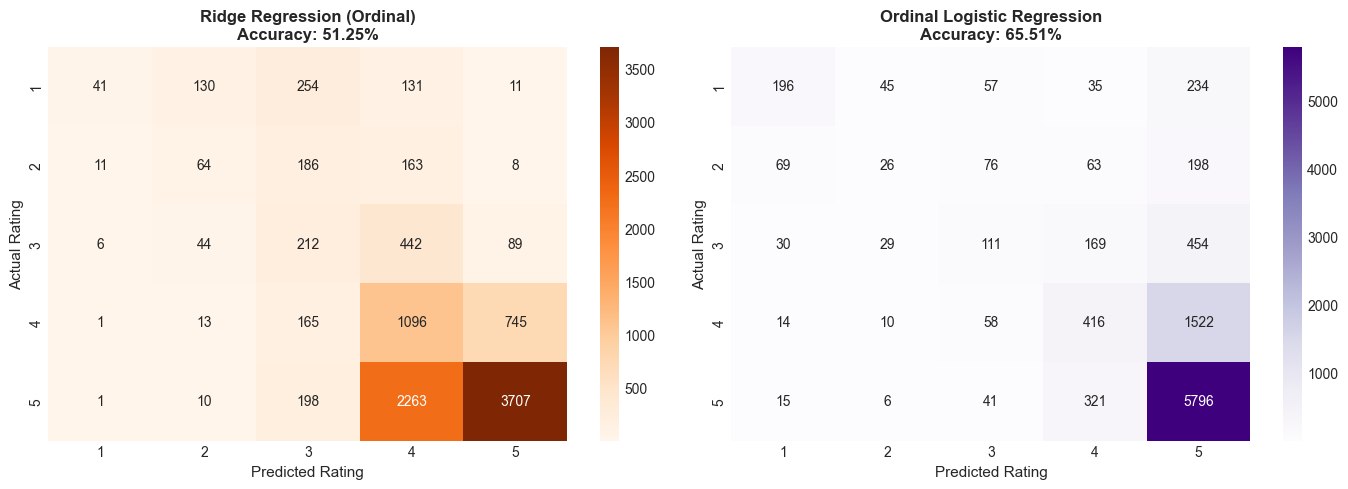


✅ Saved: confusion_matrices_ordinal.png


In [ ]:
# ============================================================================
# CONFUSION MATRICES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ridge Regression
cm_ridge = confusion_matrix(y_test, ridge_pred)
sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[0].set_xlabel('Predicted Rating', fontsize=11)
axes[0].set_ylabel('Actual Rating', fontsize=11)
axes[0].set_title(f'Ridge Regression (Ordinal)\nAccuracy: {ridge_results["accuracy"]:.2%}', 
                  fontsize=12, fontweight='bold')

# Ordinal Logistic Regression
cm_olr = confusion_matrix(y_test, olr_pred)
sns.heatmap(cm_olr, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[1].set_xlabel('Predicted Rating', fontsize=11)
axes[1].set_ylabel('Actual Rating', fontsize=11)
axes[1].set_title(f'Ordinal Logistic Regression\nAccuracy: {olr_results["accuracy"]:.2%}', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/confusion_matrices_ordinal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: results/figures/confusion_matrices_ordinal.png")

In [ ]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

# Combine results
ordinal_results = pd.DataFrame([ridge_results, olr_results])

print("\n" + "="*70)
print("📊 ORDINAL MODELS SUMMARY")
print("="*70)
print(ordinal_results.to_string(index=False))

# Save to CSV
ordinal_results.to_csv('results/tables/ordinal_results.csv', index=False)
print("\n✅ Saved: results/tables/ordinal_results.csv")


📊 ORDINAL MODELS SUMMARY
                      model encoding  accuracy      mae  f1_macro  f1_weighted  adjacent_error  severe_error
           Ridge Regression  Ordinal  0.512461 0.593534  0.319769     0.533467        0.818312      0.181688
Ordinal Logistic Regression  Ordinal  0.655090 0.535882  0.362270     0.598655        0.664248      0.335752

✅ Saved: ordinal_results.csv


In [ ]:
# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test,
    'ridge_pred': ridge_pred,
    'olr_pred': olr_pred
})
predictions_df.to_csv('results/tables/ordinal_predictions.csv', index=False)
print("✅ Saved: results/tables/ordinal_predictions.csv")

✅ Saved: ordinal_predictions.csv
